# Exploratory Data Analysis and Data Preparation

This notebook presents a comprehensive exploratory data analysis (EDA) and data preparation pipeline for the red wine quality classification task.

## 1. Dataset Overview and Initial Analysis

We begin our analysis with a dataset containing 1,599 wine samples and 11 physicochemical features, along with a target variable representing wine quality. The features include fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, and alcohol. We performed an initial analysis and found that there were no missing values in the dataset.

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

In [45]:
# Load the dataset
with open('data/raw/winequality-red.csv', 'r') as f:
    header_line = f.readline().strip()

header_clean = header_line.replace('""', '"').replace('"', '')
columns = [col.strip() for col in header_clean.split(';')]

df = pd.read_csv('data/raw/winequality-red.csv', sep=';', skiprows=1, names=columns)

In [46]:
# Check for missing values
missing = df.isnull().sum()
assert missing.sum() == 0, "Dataset contains missing values"

The distribution of feature values is summarized in the following table. An additional visualization can be found in the appendix (feature distributions) that allows us to understand the distribution of each feature, including symmetry, potential outliers, and other characteristics, which complements the table and can be verified by the reader.

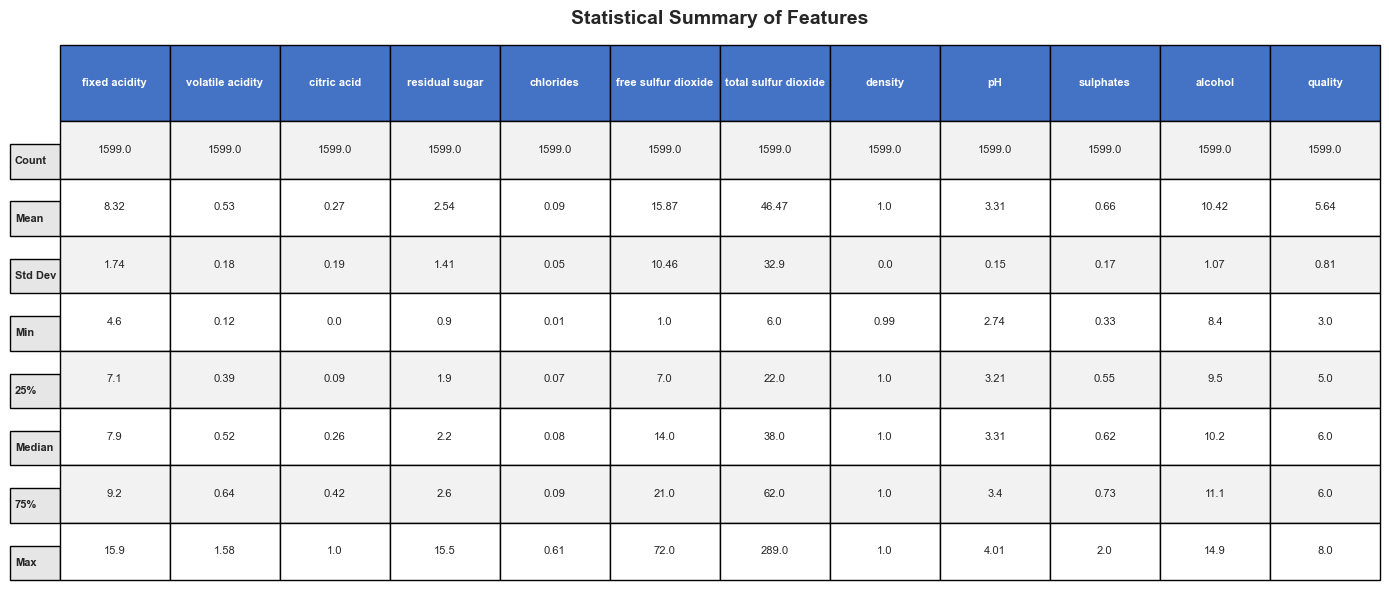

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [47]:
# Statistical summary of all features
statistical_summary = df.describe()

# Create a more beautiful table (stargazer style)
fig, ax = plt.subplots(figsize=(14, 6))
ax.axis('off')

# Prepare data
table_data = statistical_summary.round(2).values
row_labels = ['Count', 'Mean', 'Std Dev', 'Min', '25%', 'Median', '75%', 'Max']
col_labels = statistical_summary.columns.tolist()

# Create table with better styling
table = ax.table(cellText=table_data,
                 rowLabels=row_labels,
                 colLabels=col_labels,
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0, 1, 1])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(8)

# Header row styling
for i in range(len(col_labels)):
    cell = table[(0, i)]
    cell.set_facecolor('#4472C4')
    cell.set_text_props(weight='bold', color='white')
    cell.set_height(0.08)

# Row labels styling
for i in range(len(row_labels)):
    cell = table[(i+1, -1)]
    cell.set_facecolor('#E7E6E6')
    cell.set_text_props(weight='bold')
    cell.set_width(0.12)

# Alternate row colors for better readability
for i in range(len(row_labels)):
    for j in range(len(col_labels)):
        cell = table[(i+1, j)]
        if i % 2 == 0:
            cell.set_facecolor('#F2F2F2')
        else:
            cell.set_facecolor('white')
        cell.set_height(0.06)

ax.set_title('Statistical Summary of Features', fontsize=14, fontweight='bold', pad=15)

plt.tight_layout()
plt.savefig('figures/statistical_summary.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistical Summary of Features
statistical_summary

## 2. Target Variable Analysis and Feature Correlations

Wine quality serves as the target variable, taking discrete values from 3 to 8. Understanding the distribution of wine quality is essential for addressing the challenges inherent in classification tasks, particularly given the class imbalance observed in the dataset. Additionally, analyzing feature relationships is critical for identifying multicollinearity and understanding the underlying data structure that may influence model performance.

**Note:** As a team, we read the codebook and documentation of the data (Cortez et al., 2009; UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/wine+quality) and although in the description of the dictionaries the source states that quality can take values from 0 to 10, in our dataset we only found possible values from 3 to 8.

In [32]:
# Target variable distribution
quality_dist = df['quality'].value_counts().sort_index()
quality_dist

quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: count, dtype: int64

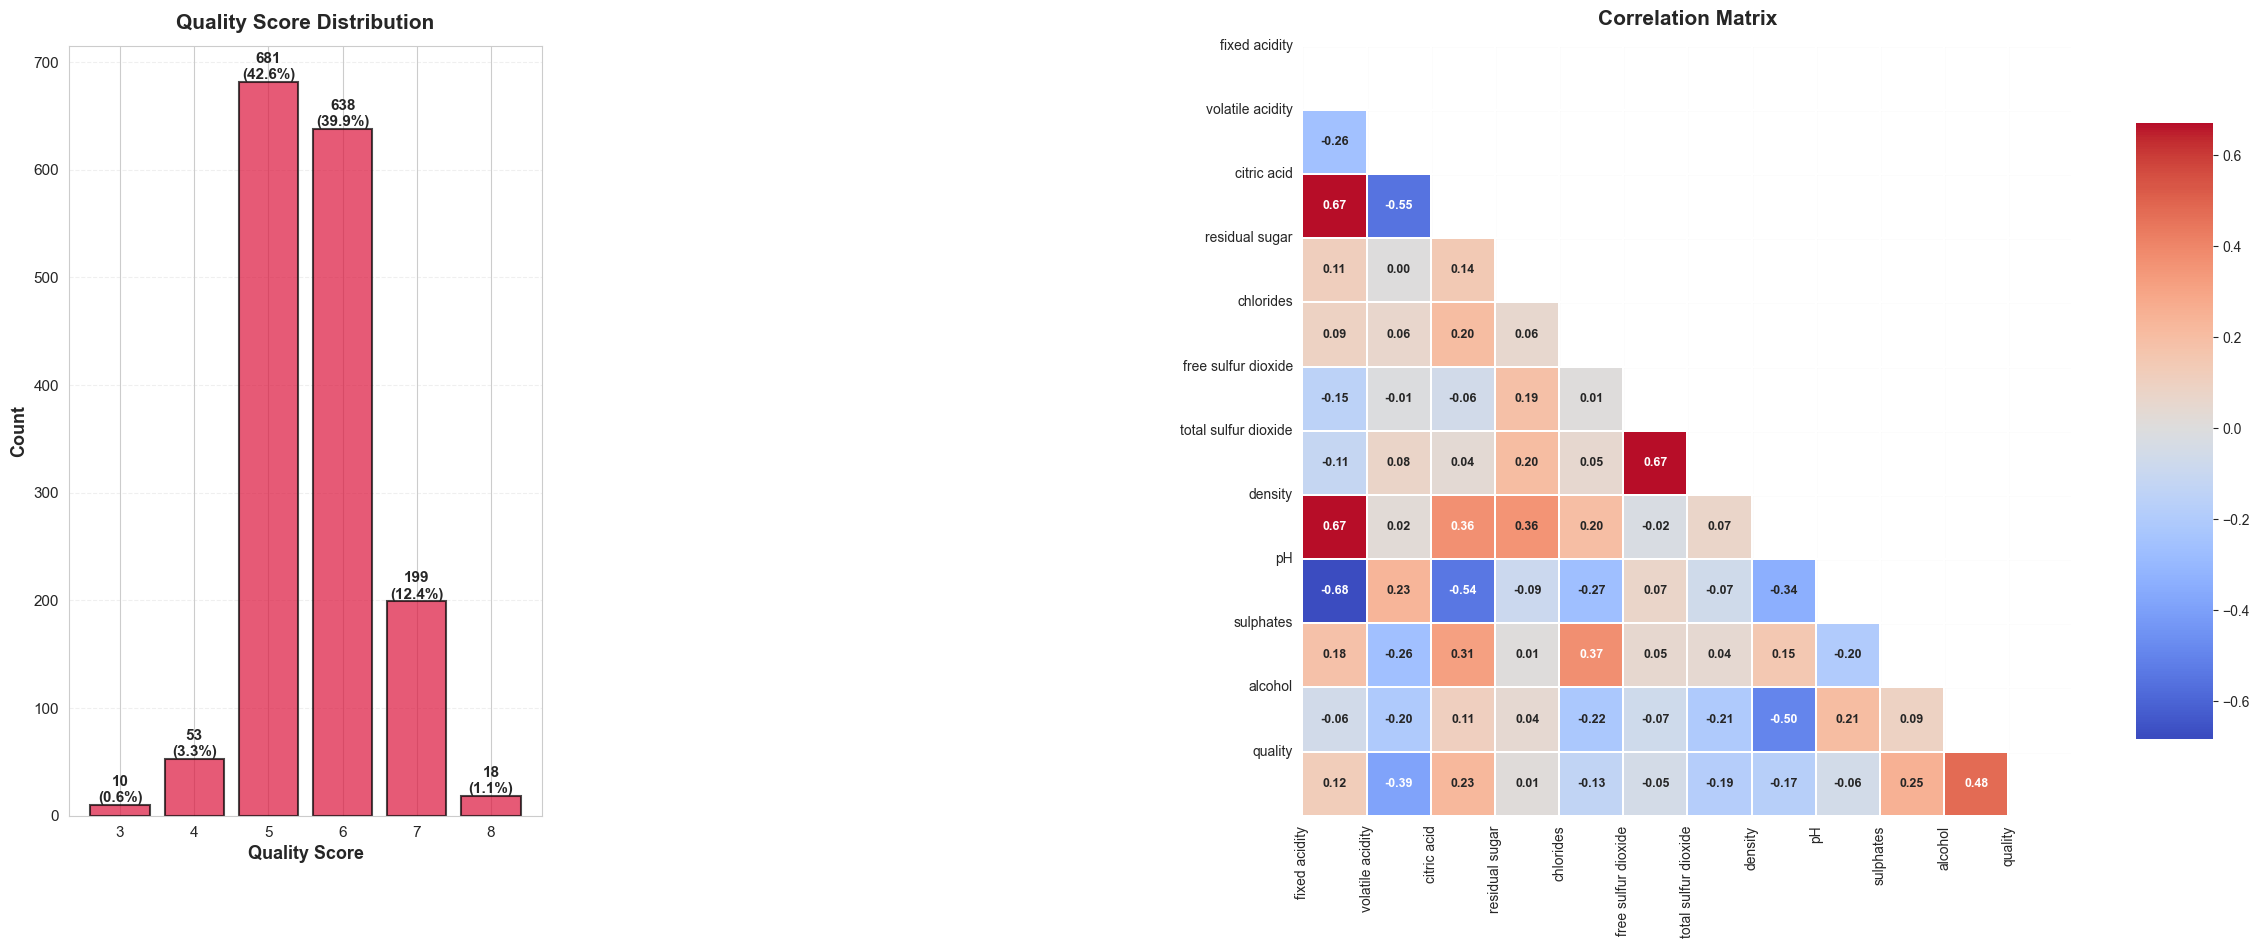

In [33]:
# Create combined figure: quality bar chart (left) and correlation matrix (right)
# Significantly increase size for PDF readability
fig, axes = plt.subplots(1, 2, figsize=(24, 10), gridspec_kw={'width_ratios': [0.6, 1.6], 'wspace': 0.6})

# Left: Quality distribution bar chart
ax1 = axes[0]
bars = ax1.bar(quality_dist.index, quality_dist.values, 
               color='crimson', alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Quality Score', fontsize=13, fontweight='bold')
ax1.set_ylabel('Count', fontsize=13, fontweight='bold')
ax1.set_title('Quality Score Distribution', fontsize=15, fontweight='bold', pad=12)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_xticks(quality_dist.index)
ax1.tick_params(axis='both', labelsize=11)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}\n({height/total*100:.1f}%)',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Right: Correlation matrix - make it much bigger for PDF
correlation_matrix = df.corr()
ax2 = axes[1]
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
heatmap = sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.25, 
            cbar_kws={"shrink": 0.8, "aspect": 8, "label": ""}, 
            annot_kws={'size': 9, 'weight': 'bold'}, ax=ax2)
ax2.set_title('Correlation Matrix', fontsize=15, fontweight='bold', pad=15)
ax2.set_xticks(range(len(correlation_matrix.columns)))
ax2.set_xticklabels(correlation_matrix.columns, fontsize=10, rotation=90)
ax2.set_yticks(range(len(correlation_matrix.columns)))
ax2.set_yticklabels(correlation_matrix.columns, fontsize=10, rotation=0)

# Adjust colorbar font size
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)

# Use subplots_adjust for better control
plt.subplots_adjust(left=0.04, right=0.98, top=0.85, bottom=0.08, wspace=0.6)
plt.savefig('figures/quality_and_correlation_combined.png', dpi=300, bbox_inches='tight')
plt.show()

The bar chart (left) reveals that this variable exhibits class imbalance, with quality levels 5 and 6 being the most frequent, respectively, while there are very few wines with low quality (such as 3) or extremely high quality (such as 8). The order of magnitude of the differences is very significant, as in our dataset there is a probability of 0.63% of having a wine with quality 3, while the probability is more than 68 times greater for quality 5 (42.59%). Similarly, quality 6 has a probability of 39.90%, which is more than 63 times greater than quality 3.

The correlation matrix (right) provides a comprehensive view of pairwise linear relationships between all physicochemical features, enabling us to assess both feature-feature interactions and feature-target associations simultaneously. Notable pairwise correlations between features include strong positive correlations between fixed acidity and citric acid (0.67), fixed acidity and density (0.67), and total sulfur dioxide and free sulfur dioxide (0.67). Strong negative correlations are observed between fixed acidity and pH (-0.68), citric acid and volatile acidity (-0.55), and citric acid and pH (-0.54). These relationships indicate potential multicollinearity that may influence model performance. By examining the quality row in the correlation matrix, we identify the strongest associations with wine quality. Alcohol content shows the strongest positive correlation (0.48), followed by sulphates (0.25) and citric acid (0.23). Conversely, volatile acidity exhibits the strongest negative correlation (-0.39), indicating that higher levels are associated with lower quality scores. Other features showing moderate negative correlations include total sulfur dioxide (-0.19) and density (-0.17). While quality is an ordinal variable, we compute Pearson correlation coefficients given its natural ordering, which allows us to capture linear trends. These correlations provide an initial indication of feature importance, though the classification models will ultimately determine the true discriminative power of each feature.

## 3. Train-Test Split

To prevent data leakage, we perform the train-test split **before** any preprocessing steps (normalization, PCA, feature interactions). All preprocessing transformations will be fitted only on the training set and then applied to the test set.

In [34]:
from sklearn.model_selection import train_test_split

# Separate features and target BEFORE any preprocessing
X = df.drop('quality', axis=1)
y = df['quality']

# Perform 80-20 train-test split with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## 4. Data Preparation and Feature Engineering

Prior to model training, it is essential to prepare the data appropriately. Machine learning algorithms, particularly Support Vector Machines (SVM) and Artificial Neural Networks (ANN), are sensitive to the scale of input features. Features with larger numerical ranges can dominate the learning process, potentially biasing the model toward those features. Therefore, we apply feature normalization to ensure all features contribute equally to the model's learning process.

**IMPORTANT:** All preprocessing steps (outlier treatment, normalization, PCA, feature interactions) are fitted **only on the training set** to prevent data leakage. The fitted transformers are then applied to both training and test sets.

### 4.1 Outlier Treatment and Normalization

Our data preparation pipeline consists of two main steps: (1) outlier detection and treatment, and (2) feature standardization. Initial analysis revealed the presence of significant outliers across multiple features, particularly in residual sugar, chlorides, and sulphates. Outliers can significantly affect the mean and standard deviation used in standardization, potentially distorting the transformation. We identify outliers using the Interquartile Range (IQR) method, which is robust to extreme values. Outliers are capped (rather than removed) to preserve the sample size. 

**Critical:** We calculate outlier bounds (IQR) **only from the training set**, then cap outliers in both train and test sets using these training-set-derived bounds. Subsequently, we fit StandardScaler **only on the training set** and apply it to both train and test sets. This ensures that test set statistics do not leak into the preprocessing pipeline.

In [ ]:
from sklearn.preprocessing import StandardScaler
import os

# Create processed data directory
os.makedirs('data/processed', exist_ok=True)

# Step 1: Outlier detection using IQR method - CALCULATE BOUNDS ONLY FROM TRAIN SET
# Calculating outlier bounds from TRAINING SET only to prevent data leakage

outliers_info = {}
outlier_bounds = {}  # Store bounds calculated from train set

for feature in X_train.columns:
    # Calculate bounds ONLY from training set
    Q1 = X_train[feature].quantile(0.25)
    Q3 = X_train[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outlier_bounds[feature] = {'lower': lower_bound, 'upper': upper_bound}
    
    # Count outliers in training set
    train_outliers = ((X_train[feature] < lower_bound) | (X_train[feature] > upper_bound)).sum()
    outliers_info[feature] = {
        'count_train': train_outliers,
        'percentage_train': (train_outliers / len(X_train)) * 100,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }

# Print outlier summary
outlier_summary = pd.DataFrame({
    'Feature': list(outliers_info.keys()),
    'Outliers (Train)': [outliers_info[f]['count_train'] for f in outliers_info.keys()],
    'Percentage (Train)': [f"{outliers_info[f]['percentage_train']:.2f}%" for f in outliers_info.keys()]
})
outlier_summary

# Cap outliers in BOTH train and test using bounds calculated from train set
X_train_processed = X_train.copy()
X_test_processed = X_test.copy()

for feature in X_train.columns:
    bounds = outlier_bounds[feature]
    X_train_processed[feature] = X_train_processed[feature].clip(
        lower=bounds['lower'], upper=bounds['upper']
    )
    X_test_processed[feature] = X_test_processed[feature].clip(
        lower=bounds['lower'], upper=bounds['upper']
    )

# Outlier bounds calculated from TRAINING SET only
# Outliers capped in both train and test using train-set-derived bounds


OUTLIER DETECTION AND TREATMENT
Calculating outlier bounds from TRAINING SET only to prevent data leakage

             Feature  Outliers (Train) Percentage (Train)
       fixed acidity                22              1.72%
    volatile acidity                20              1.56%
         citric acid                 1              0.08%
      residual sugar               123              9.62%
           chlorides                80              6.25%
 free sulfur dioxide                22              1.72%
total sulfur dioxide                41              3.21%
             density                31              2.42%
                  pH                27              2.11%
           sulphates                51              3.99%
             alcohol                11              0.86%

 Outlier bounds calculated from TRAINING SET only
 Outliers capped in both train and test using train-set-derived bounds
 Training set shape: (1279, 11)
 Test set shape: (320, 11)


In [37]:
# Step 2: Feature Standardization - FIT ONLY ON TRAIN SET
# Fitting StandardScaler on TRAINING SET only, then applying to both sets

scaler = StandardScaler()
# FIT only on training set
scaler.fit(X_train_processed)

# TRANSFORM both train and test sets
X_train_scaled = pd.DataFrame(
    scaler.transform(X_train_processed),
    columns=X_train_processed.columns,
    index=X_train_processed.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_processed),
    columns=X_test_processed.columns,
    index=X_test_processed.index
)

# Combine scaled features with targets
df_train_normalized = pd.concat([X_train_scaled, y_train], axis=1)
df_test_normalized = pd.concat([X_test_scaled, y_test], axis=1)

# Save normalized datasets
df_train_normalized.to_csv('data/processed/winequality-red-normalized-train.csv', index=False)
df_test_normalized.to_csv('data/processed/winequality-red-normalized-test.csv', index=False)

# StandardScaler fitted on TRAINING SET only
# Standardization applied to both train and test sets
# Normalized training set statistics (first 5 features)
X_train_scaled.describe().iloc[:, :5].round(3)


FEATURE STANDARDIZATION
Fitting StandardScaler on TRAINING SET only, then applying to both sets

 StandardScaler fitted on TRAINING SET only
 Standardization applied to both train and test sets
 Training set saved to: data/processed/winequality-red-normalized-train.csv
 Test set saved to: data/processed/winequality-red-normalized-test.csv

Normalized training set statistics (first 5 features):
       fixed acidity  volatile acidity  citric acid  residual sugar  chlorides
count       1279.000          1279.000     1279.000        1279.000   1279.000
mean           0.000            -0.000       -0.000           0.000      0.000
std            1.000             1.000        1.000           1.000      1.000
min           -2.253            -2.371       -1.407          -2.375     -2.365
25%           -0.726            -0.766       -0.893          -0.717     -0.641
50%           -0.237            -0.037       -0.071          -0.219     -0.094
75%            0.618             0.634        0.8

The normalized datasets contain all original features standardized to have zero mean and unit variance, with outliers appropriately treated. The standardization process transforms each feature according to the formula:

$$z = \frac{x - \mu_{train}}{\sigma_{train}}$$

where $z$ is the standardized value, $x$ is the original value, $\mu_{train}$ is the mean from the **training set**, and $\sigma_{train}$ is the standard deviation from the **training set**. This ensures that test set statistics do not leak into the preprocessing pipeline. These normalized datasets (`winequality-red-normalized-train.csv` and `winequality-red-normalized-test.csv`) will serve as the baseline for all classification models (SVM, ANN, and Random Forest), ensuring that feature scaling does not bias the learning process.

### 4.2 Feature Interactions

The correlation analysis revealed several strong pairwise relationships between features (|r| > 0.5), suggesting that these variables may interact in ways that influence wine quality. While linear models can capture individual feature effects, they may miss how the combination of features together affects the outcome. For example, the effect of fixed acidity on wine quality may depend on the level of citric acid present. To address this, we create multiplicative interaction features for the strongly correlated pairs identified in the correlation matrix. These interactions are created as multiplicative terms between standardized features, allowing us to evaluate whether explicitly modeling feature interactions improves classification performance compared to the baseline normalized dataset.

In [38]:
# Feature Interactions - create separately for train and test
X_train_interactions = X_train_scaled.copy()
X_test_interactions = X_test_scaled.copy()

interaction_pairs = [
    ('fixed acidity', 'citric acid', ''),
    ('fixed acidity', 'density', ''),
    ('total sulfur dioxide', 'free sulfur dioxide', ''),
    ('fixed acidity', 'pH', '_neg'),
    ('citric acid', 'volatile acidity', '_neg'),
    ('citric acid', 'pH', '_neg'),
    ('alcohol', 'density', '_neg')
]

for feat1, feat2, suffix in interaction_pairs:
    interaction_name = f"{feat1}_{feat2}_interaction{suffix}"
    X_train_interactions[interaction_name] = X_train_scaled[feat1] * X_train_scaled[feat2]
    X_test_interactions[interaction_name] = X_test_scaled[feat1] * X_test_scaled[feat2]

# Save datasets with interactions
df_train_interactions = pd.concat([X_train_interactions, y_train], axis=1)
df_test_interactions = pd.concat([X_test_interactions, y_test], axis=1)
df_train_interactions.to_csv('data/processed/winequality-red-interactions-train.csv', index=False)
df_test_interactions.to_csv('data/processed/winequality-red-interactions-test.csv', index=False)

The datasets with interactions (`winequality-red-interactions-train.csv` and `winequality-red-interactions-test.csv`) contain all original standardized features plus interaction terms for strongly correlated feature pairs. Interactions are created separately for train and test sets using the normalized features. These datasets allow us to evaluate whether capturing explicit feature interactions improves classification performance compared to the baseline normalized dataset.

## 5. Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is a dimensionality reduction technique that transforms the original features into a new set of uncorrelated variables called principal components. These components are ordered by the amount of variance they explain in the data. PCA serves two purposes in our analysis: (1) visualization of high-dimensional data in lower-dimensional space (2D/3D), which is mandatory for this project, and (2) as an alternative dataset for model training, allowing us to compare classification performance with and without dimensionality reduction.

**CRITICAL:** We fit PCA **only on the normalized training set** to prevent data leakage. The fitted PCA model is then used to transform both the training and test sets. This ensures that principal components are learned only from training data, and test set information does not influence the dimensionality reduction.

We apply PCA to the normalized training dataset to ensure that all features contribute equally to the principal components. The scree plot and cumulative explained variance plot (see Figure A4 in the appendix) reveal how many components are needed to capture the majority of the variance in the **training data**. The analysis shows that 7 components are required to retain 90% of the variance, while 9 components capture 95% of the total variance. This suggests that dimensionality reduction is feasible, as most information can be preserved with fewer components than the original 11 features. The visualization in 2D and 3D space helps us understand the separability of different quality classes in the reduced-dimensional space.

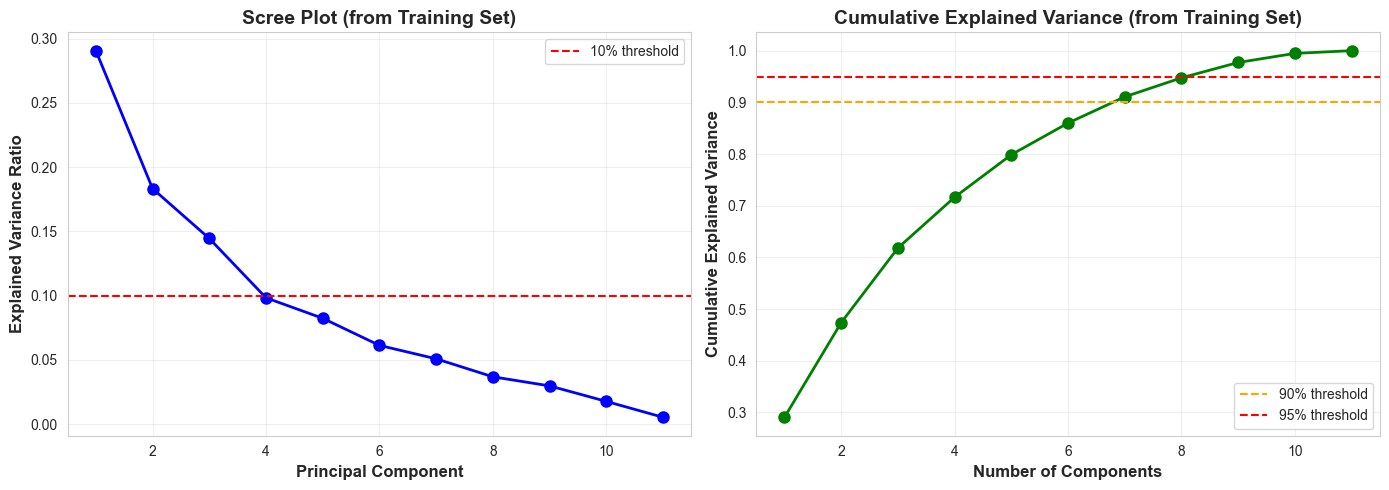

In [39]:
from sklearn.decomposition import PCA

# PCA - FIT ONLY ON TRAIN SET
pca = PCA()
pca.fit(X_train_scaled)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

# Visualize explained variance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(range(1, len(pca.explained_variance_ratio_) + 1), 
             pca.explained_variance_ratio_, 'bo-', linewidth=2, markersize=8)
axes[0].axhline(y=0.1, color='r', linestyle='--', label='10% threshold')
axes[0].set_xlabel('Principal Component', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Explained Variance Ratio', fontsize=12, fontweight='bold')
axes[0].set_title('Scree Plot (from Training Set)', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].legend()

axes[1].plot(range(1, len(cumulative_variance) + 1), 
             cumulative_variance, 'go-', linewidth=2, markersize=8)
axes[1].axhline(y=0.90, color='orange', linestyle='--', label='90% threshold')
axes[1].axhline(y=0.95, color='red', linestyle='--', label='95% threshold')
axes[1].set_xlabel('Number of Components', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=12, fontweight='bold')
axes[1].set_title('Cumulative Explained Variance (from Training Set)', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.savefig('figures/pca_variance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

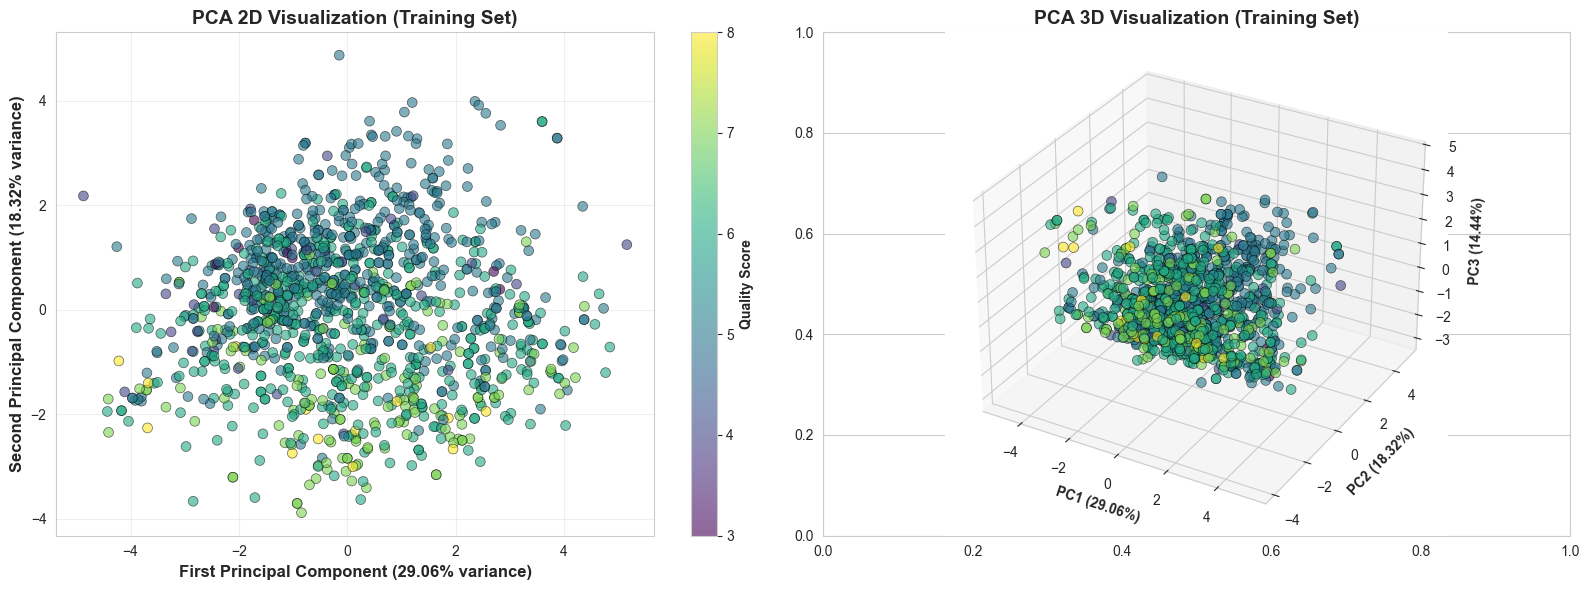

In [40]:
# PCA Visualization (2D and 3D) - using training data
pca_2d = PCA(n_components=2)
X_train_pca_2d = pca_2d.fit_transform(X_train_scaled)

pca_3d = PCA(n_components=3)
X_train_pca_3d = pca_3d.fit_transform(X_train_scaled)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
scatter = axes[0].scatter(X_train_pca_2d[:, 0], X_train_pca_2d[:, 1], c=y_train, cmap='viridis', 
                          alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel(f'First Principal Component ({pca_2d.explained_variance_ratio_[0]*100:.2f}% variance)', 
                   fontsize=12, fontweight='bold')
axes[0].set_ylabel(f'Second Principal Component ({pca_2d.explained_variance_ratio_[1]*100:.2f}% variance)', 
                   fontsize=12, fontweight='bold')
axes[0].set_title('PCA 2D Visualization (Training Set)', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=axes[0])
cbar.set_label('Quality Score', fontsize=10, fontweight='bold')

ax_3d = fig.add_subplot(122, projection='3d')
scatter_3d = ax_3d.scatter(X_train_pca_3d[:, 0], X_train_pca_3d[:, 1], X_train_pca_3d[:, 2], 
                          c=y_train, cmap='viridis', alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
ax_3d.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]*100:.2f}%)', fontsize=10, fontweight='bold')
ax_3d.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]*100:.2f}%)', fontsize=10, fontweight='bold')
ax_3d.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]*100:.2f}%)', fontsize=10, fontweight='bold')
ax_3d.set_title('PCA 3D Visualization (Training Set)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('figures/pca_visualization_2d_3d.png', dpi=300, bbox_inches='tight')
plt.show()

In [41]:
# Create PCA dataset - FIT ON TRAIN, TRANSFORM BOTH TRAIN AND TEST
pca_model = PCA(n_components=n_components_95)
X_train_pca_model = pca_model.fit_transform(X_train_scaled)
X_test_pca_model = pca_model.transform(X_test_scaled)

pca_columns = [f'PC{i+1}' for i in range(n_components_95)]
df_train_pca = pd.DataFrame(X_train_pca_model, columns=pca_columns, index=X_train_scaled.index)
df_test_pca = pd.DataFrame(X_test_pca_model, columns=pca_columns, index=X_test_scaled.index)

df_train_pca = pd.concat([df_train_pca, y_train], axis=1)
df_test_pca = pd.concat([df_test_pca, y_test], axis=1)
df_train_pca.to_csv('data/processed/winequality-red-pca-train.csv', index=False)
df_test_pca.to_csv('data/processed/winequality-red-pca-test.csv', index=False)

The PCA visualization reveals the separability of different quality classes in the reduced-dimensional space. While perfect separation is not expected in 2D or 3D projections (as they capture only a portion of the total variance), the visualization provides insights into the underlying structure of the data. The PCA-transformed datasets (`winequality-red-pca-train.csv` and `winequality-red-pca-test.csv`) will be used as an alternative input for classification models, allowing us to compare performance with the normalized dataset and assess whether dimensionality reduction improves or hinders classification accuracy. **Critical:** The PCA model is fitted only on the training set, ensuring that test set information does not leak into the dimensionality reduction process.

## 6. Oversampling with SMOTE

The severe class imbalance observed in the dataset (with quality levels 3 and 8 representing less than 2% of samples) poses a significant challenge for classification models. While optimizing for macro F1-score helps address this issue, we also explore oversampling techniques to balance the class distribution in the training data.

**SMOTE (Synthetic Minority Oversampling Technique)** generates synthetic samples for minority classes by interpolating between existing minority class examples. This approach helps models learn better decision boundaries for underrepresented classes without simply duplicating existing samples.

**CRITICAL:** SMOTE is applied **only to the training set** after normalization. The test set remains unchanged to provide an unbiased evaluation of model performance on the original class distribution. This ensures that synthetic samples do not leak into the test set evaluation.

In [42]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to normalized training set only
# NOTE: Test set uses winequality-red-normalized-test.csv (no SMOTE applied)
smote = SMOTE(random_state=42, k_neighbors=3)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

df_train_oversampling = pd.DataFrame(X_train_smote, columns=X_train_scaled.columns)
df_train_oversampling = pd.concat([df_train_oversampling, pd.Series(y_train_smote, name='quality')], axis=1)
df_train_oversampling.to_csv('data/processed/winequality-red-oversampling-train.csv', index=False)

The oversampled training dataset (`winequality-red-oversampling-train.csv`) contains all original standardized features with synthetic samples added for minority classes, resulting in a balanced class distribution. This dataset allows us to evaluate whether addressing class imbalance through oversampling improves classification performance, particularly for minority classes (quality levels 3, 4, and 8). The test set remains unchanged to ensure realistic evaluation of model performance on the original imbalanced distribution.

### A3. Feature Correlations with Quality Score

A detailed analysis focusing specifically on feature correlations with the quality score is presented below, providing a focused perspective on feature-target relationships.

In [ ]:
# Correlation with target variable (quality) - for appendix
quality_corr = df.corr()['quality'].sort_values(ascending=False)
quality_corr = quality_corr.drop('quality')

plt.figure(figsize=(10, 6))
colors = ['red' if x < 0 else 'green' for x in quality_corr.values]
bars = plt.barh(quality_corr.index, quality_corr.values, color=colors, alpha=0.7)
plt.xlabel('Correlation with Quality', fontsize=12, fontweight='bold')
plt.title('Feature Correlation with Quality Score', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (idx, val) in enumerate(quality_corr.items()):
    plt.text(val + 0.01 if val > 0 else val - 0.01, i, f'{val:.3f}', 
             va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('figures/quality_correlation_bar.png', dpi=300, bbox_inches='tight')
plt.show()

# Top features correlated with quality
quality_corr.abs().sort_values(ascending=False)